In [ ]:
import innvestigate

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, \
                        BatchNormalization, Conv2D, MaxPooling2D, Concatenate, Add, Conv1D
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils
from keras import callbacks

import json
import pickle
from datetime import datetime, timedelta

In [239]:
indicators = ['Maize', 'Natrual gas', 'CPI Price, seas. adj.', 'Exchange rate', 'Stock Markets', 'Unemployment Rate', 'tempF', 'precipMM', 'twitter sentiment', 'twitter volume', 'hist']
longitude = 60
lap = 7
city = 'amman'
if city=='cairo' or 'amman':
    num_classes = 3
else:
    num_classes = 5
tweet_longitude = 60
tweet_lap = 7

In [240]:
tweet_model = Sequential()
#use cnn to learn festures
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=5, strides=1, activation='relu'), input_shape=(tweet_longitude,30,300,1)))
# tweet_model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))
tweet_model.add(TimeDistributed(Dropout(0.3)))
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=5, strides=1, activation='relu')))
tweet_model.add(TimeDistributed(Dropout(0.3)))
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=3, strides=1, activation='relu')))
tweet_model.add(TimeDistributed(Dropout(0.3)))
# tweet_model.add(TimeDistributed(Conv2D(1, (5, 5), activation='relu')))
# tweet_model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
tweet_model.add(TimeDistributed(Flatten()))
tweet_model.add(TimeDistributed(Dense(128, activation='relu')))
tweet_model.add(LSTM(128))


#lstm
hist_model = Sequential()
hist_model.add(Conv1D(filters=48, kernel_size=5, strides=1, padding='same', input_shape=(longitude*len(indicators)-1,2)))
hist_model.add(Dropout(0.3))
hist_model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same'))
hist_model.add(Dropout(0.3))
# hist_model.add(Conv1D(filters=96, kernel_size=3, strides=1, padding='same'))
# hist_model.add(Dropout(0.3))
hist_model.add(LSTM(128))
# hist_model.add(Flatten())
hist_model.add(Dense(128, activation='relu'))

#concatenate
decoder1 = Add()([tweet_model.output, hist_model.output])
decoder2 = Dense(128, activation='relu')(decoder1)
outputs = Dense(3, activation='softmax')(decoder2)
model = Model(inputs=[tweet_model.input, hist_model.input], outputs=outputs)
model_without_softmax = Model(inputs=[tweet_model.input, hist_model.input], outputs=decoder2)

In [241]:
model.load_weights('')
model_without_softmax.set_weights(model.get_weights())

In [242]:
def getHistorical(date, longitude, city):
    if city=='cairo':
        sheet = 'Egypt'
    elif city=='amman':
        sheet = 'Jordan'
    elif city=='delhi':
        sheet = 'India'
    else:
        print('invalid city')
        return None
    
    df = pd.read_excel('', sheet_name=sheet, converters={'Date':str})
    for i in df.index:
        if(df['Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['ACLED'][i-longitude])
                i += 1
            return res


def getIndicators(date, city, longitude, indicator):
    df = pd.read_excel('', sheet_name=city, converters={'Date':str})
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        for i in df.index:
            if(str(df['Date'][i]).startswith(days1[x][0:7])):
                res.append(round(float(df[indicator][i]), 2))
    return res

def getCommodity(date, city, longitude, indicator):
    if city=='cairo':
        sheet = 'Egypt'
    elif city=='amman':
        sheet = 'Jordan'
    elif city=='delhi':
        sheet = 'India'
    else:
        print('invalid city')
        return None
    
    df = pd.read_excel('', sheet_name=sheet, converters={'Date':str})
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        for i in df.index:
            if(str(df['Date'][i]).startswith(days1[x][0:7])):
                res.append(round(float(df[indicator][i]), 2))
    return res

def getWeather(date, city, longitude, category):
    with open('/'+city+'/weather-dic.json') as f:
        weather = json.load(f)
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        res.append(weather[days1[x]]['hourly'][0][category])
    return res

def twitterSentiment(date, longitude, city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    df = pd.read_excel(path, sheet_name='Social unrest events prediction', converters={'Analysis Date':str})
    for i in df.index:
        if(df['Analysis Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['Anger'][i-longitude])
                i += 1
            return res

def twitterVolume(date, longitude, city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    df = pd.read_excel(path, sheet_name='Social unrest events prediction', converters={'Date':str})
    for i in df.index:
        if(df['Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['Relevant Posts'][i-longitude])
                i += 1
            return res

def loadTruth(city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    else:
        print('invalid city')
        return None
    
    with open(path) as f:
        data = json.load(f)
    return data

In [243]:
truths = loadTruth(city)
for date in truths.keys():
    c = truths[date]
    if c>=num_classes:
        c = num_classes-1
    truths[date] = np_utils.to_categorical(c, num_classes=num_classes)

In [244]:
def createIndicatorTest(date, longitude, lap, city, indicators):
    res = {}
    indic = []
    print(date)
    for indicator in indicators:
        if indicator == 'hist':
            indic.append(getHistorical(date, longitude, city))
        elif indicator == 'precipMM' or indicator == 'tempF':
            indic.append(getWeather(date, city, longitude, indicator))
        elif indicator == 'twitter sentiment':
            indic.append(twitterSentiment(date, longitude, city))
        elif indicator == 'twitter volume':
            indic.append(twitterVolume(date, longitude, city))
        elif indicator == 'Cotton' or indicator == 'Rice' or indicator == 'Wheat' or indicator == 'Maize' or indicator == 'Sugar' or indicator == 'Gold' or indicator == 'Natrual gas' or indicator == 'Iron ore' or indicator =='Copper':
            indic.append(getCommodity(date, city, longitude, indicator))
        elif indicator == 'hate':
            indic.append(getHateSpeech(date, city, longitude))
        else:
            indic.append(getIndicators(date, city, longitude, indicator))
    lengths = [len(feature) for feature in indic]
    total_points = sum(lengths)
    vector = np.zeros((total_points, 2), dtype=np.float32)
    current = 0
    for feature in indic:
        vector[current:(current + len(feature)),0] = feature
        current += len(feature)
        vector[current - 1, 1] = 1  # stroke_end
    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(vector[:, 0:1], axis=0)
    upper = np.max(vector[:, 0:1], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    vector[:, 0:1] = (vector[:, 0:1] - lower) / scale
    # 2. Compute deltas.
    vector[1:, 0:1] -= vector[0:-1, 0:1]
    vector = vector[1:, :]

    current = (datetime.strptime(date, '%Y-%m-%d')+timedelta(days=lap)).strftime('%Y-%m-%d')
    res[current] = vector
    return res

In [245]:
def preprocess(img):
    x = img[:30]
    return x

# Function to encode the data for a given date into (30, 300, longitude)
def encode(img, date, longitude, lap):
    res = np.zeros(shape=(30, 300, longitude))
    days = [datetime.strptime(date, '%Y-%m-%d') - timedelta(days=x) for x in range(lap, longitude+lap)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    days1.reverse()
    for i in range(len(days1)-1):
        print(days1[i])
        image = img[str.encode(days1[i])]
        image = preprocess(image) # crop the image
        res[:,:,i] = image
    return res

In [235]:
images = ''
# Load tweet matrix
with open(images, 'rb') as f:
    img = pickle.load(f, encoding='bytes')

In [ ]:
start_date = '2019-02-14'
end_date = '2019-02-14'

days_min = datetime.strptime(start_date, '%Y-%m-%d')
days_max = datetime.strptime(end_date, '%Y-%m-%d')
days = [days_min + timedelta(days=x) for x in range((days_max-days_min).days + 2)]
days1 = [x.strftime('%Y-%m-%d') for x in days]

y_indic = []
y_tweet = []
for i in range(len(days1)-1):
    ind = createIndicatorTest(days1[i],longitude, lap, city, indicators)
    y_indic.append(ind)
    
    y_twee = {}
    for t in ind.keys():
        encoded = encode(img, t, tweet_longitude, tweet_lap)
        encoded = np.expand_dims(encoded, axis=3)
        y_twee[t] = np.moveaxis(encoded, 2, 0)
    y_tweet.append(y_twee)

In [247]:
import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras

from keras.datasets import mnist
from keras.models import Model
from keras import optimizers

from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=5):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5

    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

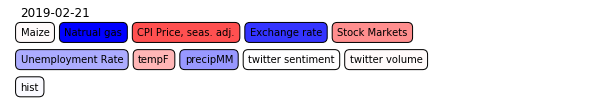

In [248]:
for i in range(len(y_indic)):
    X1, X2, y = list(), list(), list()
    for key in y_indic[i].keys():
        tweet = y_tweet[i][key]
        hist = y_indic[i][key]
        truth = truths[key]

        X1.append(tweet)
        X2.append(hist)
        y.append(truth)
    x_test = [array(X1), array(X2)]
    y_test = array(y)
    
    analyzer = innvestigate.create_analyzer("gradient", model_without_softmax)
    
    analysis = analyzer.analyze(x_test)
    
    a = np.squeeze(analysis[1])
    a = np.sum(a, axis=1)
    
    score = []
    begin = 0
    for idx,x in enumerate(x_test[1][0]):
        if x[1] == 1:
            s = sum(x_test[1][0][begin:idx+1])[0]
            score.append(s/(idx-begin+1))
            begin = idx+1
            
    plot_text_heatmap(indicators,np.asarray(score), title=key)
    plt.show()
#     plt.savefig('./'+city+'.pdf')